In [7]:
import cv2
import numpy as np
import os

# 全局变量
points = []
current_img = None
img_display = None

def click_event(event, x, y, flags, param):
    global points, img_display
    if event == cv2.EVENT_LBUTTONDOWN:
        # 记录坐标
        points.append((x, y))
        
        # 实时显示：前3个红点，后2个黄点
        color = (0, 0, 255) if len(points) <= 3 else (0, 255, 255)
        cv2.circle(img_display, (x, y), 5, color, -1)
        
        # 实时标注编号
        cv2.putText(img_display, str(len(points)), (x + 10, y - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        cv2.imshow("Manual Mark", img_display)

def solve_circle_3pts(p1, p2, p3):
    """根据三个点坐标通过几何法解圆心和半径"""
    x1, y1 = p1; x2, y2 = p2; x3, y3 = p3
    D = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    if D == 0: return None
    xc = ((x1**2 + y1**2) * (y2 - y3) + (x2**2 + y2**2) * (y3 - y1) + (x3**2 + y3**2) * (y1 - y2)) / D
    yc = ((x1**2 + y1**2) * (x3 - x2) + (x2**2 + y2**2) * (x1 - x3) + (x3**2 + y3**2) * (x2 - x1)) / D
    r = np.sqrt((x1 - xc)**2 + (y1 - yc)**2)
    return xc, yc, r

def run_manual_marking(input_dir, output_dir):
    global points, current_img, img_display
    
    if not os.path.exists(output_dir): os.makedirs(output_dir)
    files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    
    print("--- 人工标记说明 ---")
    print("1. 依次点击液滴圆弧上的 3 个点 (红色)")
    print("2. 依次点击基准线(表面)上的 2 个点 (黄色)")
    print("3. 按 'c' 键计算并保存，按 'r' 重置，按 'q' 退出")

    for filename in files:
        points = []
        img_path = os.path.join(input_dir, filename)
        current_img = cv2.imread(img_path)
        img_display = current_img.copy()
        
        cv2.imshow("Manual Mark", img_display)
        cv2.setMouseCallback("Manual Mark", click_event)
        
        while True:
            key = cv2.waitKey(1) & 0xFF
            if key == ord('r'): # 重置当前图片
                points = []
                img_display = current_img.copy()
                cv2.imshow("Manual Mark", img_display)
            elif key == ord('q'): # 退出程序
                cv2.destroyAllWindows()
                return
            elif key == ord('c') and len(points) == 5: # 计算并保存
                # --- 1. 计算拟合数据 ---
                xc, yc, r = solve_circle_3pts(points[0], points[1], points[2])
                p4, p5 = points[3], points[4]
                
                # 基准线平均高度
                baseline_y_avg = (p4[1] + p5[1]) / 2
                dy = abs(baseline_y_avg - yc)
                dx = np.sqrt(max(0, r**2 - dy**2))
                
                # 计算接触角
                theta_rad = np.arctan2(dx, dy)
                theta_deg = np.degrees(theta_rad) if yc < baseline_y_avg else 180 - np.degrees(theta_rad)
                
                # --- 2. 绘制保存用的图片 (包含所有标记点) ---
                res_plot = current_img.copy()
                
                # A. 绘制 5 个原始标记点和编号
                for i, pt in enumerate(points):
                    dot_color = (0, 0, 255) if i < 3 else (0, 255, 255) # 前3红后2黄
                    cv2.circle(res_plot, pt, 6, dot_color, -1) # 画实心点
                    cv2.putText(res_plot, str(i+1), (pt[0]+10, pt[1]-10), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, dot_color, 2)
                
                # B. 绘制拟合圆 (红色虚线感)
                cv2.circle(res_plot, (int(xc), int(yc)), int(r), (0, 0, 255), 2)
                
                # C. 绘制拟合基线 (延长线，黄色)
                # 为了美观，画一条贯穿左右标记点的长线
                ext_len = 100
                cv2.line(res_plot, (p4[0]-ext_len, p4[1]), (p5[0]+ext_len, p5[1]), (0, 255, 255), 2)
                
                # D. 标注接触角数值
                text_bg = (int(points[1][0]), int(points[1][1] - 50)) # 在液滴上方显示
                cv2.putText(res_plot, f"CA: {theta_deg:.2f} deg", (50, 60), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)
                
                # --- 3. 保存 ---
                save_path = os.path.join(output_dir, f"manual_marked_{filename}")
                cv2.imwrite(save_path, res_plot)
                print(f"已保存包含标记点的图片: {filename} | 角度: {theta_deg:.2f}°")
                break
                
        if key == ord('q'): break

    cv2.destroyAllWindows()
    print("所有图片处理完成！")

# --- 设置路径运行 ---
# 请确保文件夹路径存在
input_folder = r"C:\Users\Admin\Desktop\CA\CA_photo"
output_folder = r"C:\Users\Admin\Desktop\CA\CA_manual_results"

run_manual_marking(input_folder, output_folder)

--- 人工标记说明 ---
1. 依次点击液滴圆弧上的 3 个点 (红色)
2. 依次点击基准线(表面)上的 2 个点 (黄色)
3. 按 'c' 键计算并保存，按 'r' 重置，按 'q' 退出
已保存包含标记点的图片: 1000-1.jpg | 角度: 109.66°
已保存包含标记点的图片: 1000-2.jpg | 角度: 112.39°
已保存包含标记点的图片: 1000-3.jpg | 角度: 112.70°
已保存包含标记点的图片: 10000-1.jpg | 角度: 122.66°
已保存包含标记点的图片: 10000-2.jpg | 角度: 120.77°
已保存包含标记点的图片: 10000-3.jpg | 角度: 122.96°
已保存包含标记点的图片: 120-1.jpg | 角度: 119.20°
已保存包含标记点的图片: 120-2.jpg | 角度: 111.91°
已保存包含标记点的图片: 120-3.jpg | 角度: 114.40°
已保存包含标记点的图片: 120-4.jpg | 角度: 118.16°
已保存包含标记点的图片: 1200-1.jpg | 角度: 121.39°
已保存包含标记点的图片: 1200-2.jpg | 角度: 128.13°
已保存包含标记点的图片: 1200-3.jpg | 角度: 127.34°
已保存包含标记点的图片: 1500-1.jpg | 角度: 118.20°
已保存包含标记点的图片: 1500-2.jpg | 角度: 116.23°
已保存包含标记点的图片: 1500-3.jpg | 角度: 114.51°
已保存包含标记点的图片: 2000-1.jpg | 角度: 116.07°
已保存包含标记点的图片: 2000-2.jpg | 角度: 114.83°
已保存包含标记点的图片: 2000-3.jpg | 角度: 113.95°
已保存包含标记点的图片: 240-1.jpg | 角度: 108.59°
已保存包含标记点的图片: 240-2.jpg | 角度: 107.61°
已保存包含标记点的图片: 240-3.jpg | 角度: 115.89°
已保存包含标记点的图片: 2500-1.jpg | 角度: 120.07°
已保存包含标记点的图片: 2500-2.jpg | 角度: 

C:\Users\Admin\AppData\Local\Temp\ipykernel_4332\84053549.py:49: UserWarning: Glyph 31890 (\N{CJK UNIFIED IDEOGRAPH-7C92}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_4332\84053549.py:49: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_4332\84053549.py:49: UserWarning: Glyph 32534 (\N{CJK UNIFIED IDEOGRAPH-7F16}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_4332\84053549.py:49: UserWarning: Glyph 21495 (\N{CJK UNIFIED IDEOGRAPH-53F7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_4332\84053549.py:49: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_4332\84053549.py:49: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEO

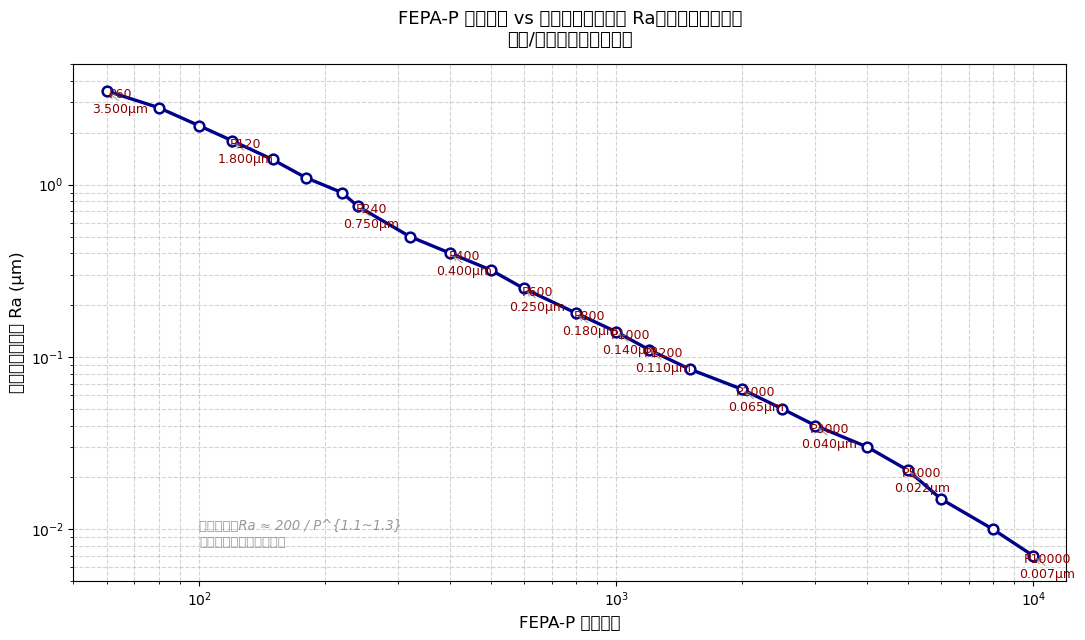

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# FEPA-P 粒度编号（常用范围 + 一些高目数）
p_grit = np.array([
    60, 80, 100, 120, 150, 180, 220, 240, 320, 400,
    500, 600, 800, 1000, 1200, 1500, 2000, 2500, 3000, 4000, 5000, 6000, 8000, 10000
])

# 对应的大致 Ra 值（μm）——金属/不锈钢常见湿磨/逐步递进打磨后的**经验中间值**
# 注意：实际值受材料、压力、润滑、是否逐级递进等影响极大，仅供参考！
ra_values = np.array([
    3.50, 2.80, 2.20, 1.80, 1.40, 1.10, 0.90, 0.75, 0.50, 0.40,   # P60~P400
    0.32, 0.25, 0.18, 0.14, 0.11, 0.085, 0.065, 0.050, 0.040, 0.030,  # P500~P4000
    0.022, 0.015, 0.010, 0.007                                          # P5000~P10000
])

# 画图
plt.figure(figsize=(11, 6.5))

plt.loglog(p_grit, ra_values, 'o-', color='darkblue', linewidth=2.4, markersize=7,
           markerfacecolor='white', markeredgecolor='darkblue', markeredgewidth=1.8)

# 标注一些关键点
important = [60, 120, 240, 400, 600, 800, 1000, 1200, 2000, 3000, 5000, 10000]
for grit in important:
    idx = np.where(p_grit == grit)[0][0]
    ra = ra_values[idx]
    plt.annotate(f'P{grit}\n{ra:.3f}μm', 
                 (p_grit[idx], ra), 
                 xytext=(10, -16), textcoords='offset points',
                 fontsize=9, color='darkred', ha='center',
                 arrowprops=dict(arrowstyle='->', color='gray', lw=0.9, alpha=0.7))

plt.grid(True, which="both", ls="--", alpha=0.55)

plt.title("FEPA-P 砂纸粒度 vs 打磨后表面粗糙度 Ra（经验近似曲线）\n金属/不锈钢湿磨常见范围", 
          fontsize=13, pad=14)
plt.xlabel("FEPA-P 粒度编号", fontsize=12)
plt.ylabel("预期表面粗糙度 Ra (μm)", fontsize=12)

plt.xlim(50, 12000)
plt.ylim(0.005, 5)

# 添加一个经验参考公式（仅示意，实际不是严格幂律）
plt.text(100, 0.008, "粗略经验：Ra ≈ 200 / P^{1.1~1.3}\n（高目数区域下降变缓）", 
         fontsize=9.5, color='gray', alpha=0.8, style='italic')

plt.tight_layout()
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_4332\2838663140.py:42: UserWarning: Glyph 30446 (\N{CJK UNIFIED IDEOGRAPH-76EE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_4332\2838663140.py:42: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_4332\2838663140.py:42: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_4332\2838663140.py:42: UserWarning: Glyph 21051 (\N{CJK UNIFIED IDEOGRAPH-523B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_4332\2838663140.py:42: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_4332\2838663140.py:42: UserWarning: Glyph 25490 (\N{CJK 

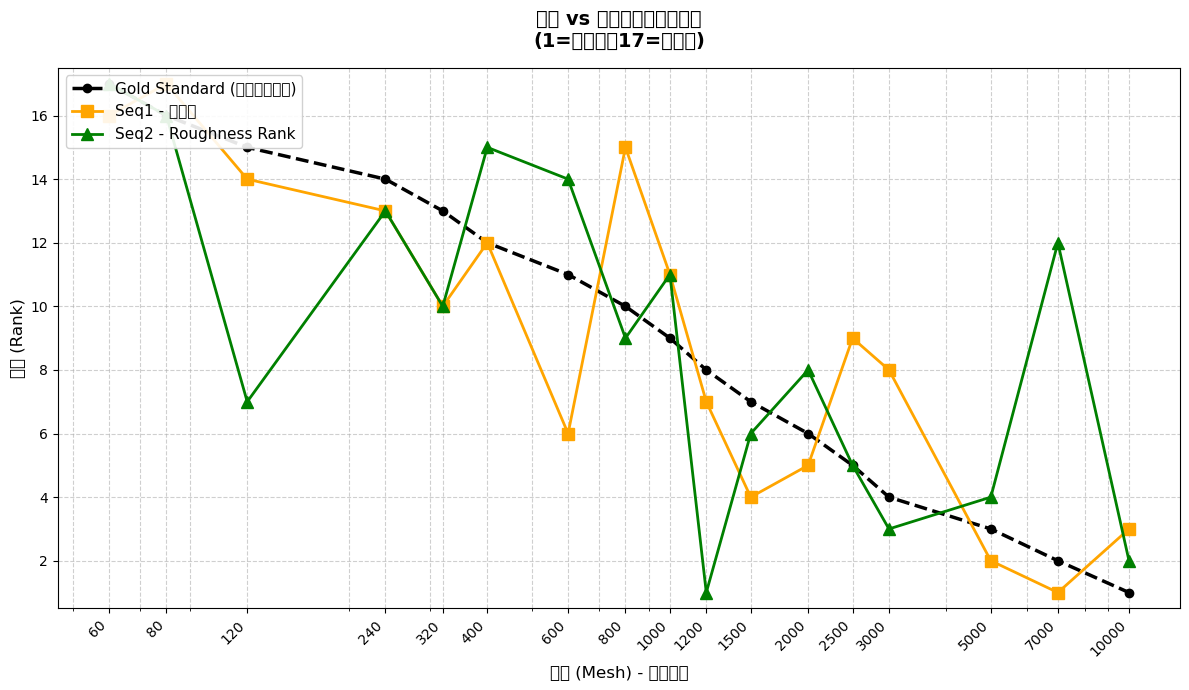

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 数据（目数从小到大排序）
mesh = [60, 80, 120, 240, 320, 400, 600, 800, 1000, 1200, 1500, 2000, 2500, 3000, 5000, 7000, 10000]

# 排名数据（1=最光滑，17=最粗糙）
gold_rank   = [17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1]      # 理论金标准（目数越大排名越靠前）
seq1_rank   = [16,17,14,13,10,12,6,15,11,7,4,5,9,8,2,1,3]     # 数值法排名
seq2_rank   = [17,16,7,13,10,15,14,9,11,1,6,8,5,3,4,12,2]     # Roughness_Rank排名

# 创建图表
plt.figure(figsize=(12, 7), dpi=100)

# 对数刻度横轴
plt.xscale('log')

# 画三条折线
plt.plot(mesh, gold_rank,   'k--', linewidth=2.5, label='Gold Standard (理论目数排名)', marker='o')
plt.plot(mesh, seq1_rank,   'orange', linewidth=2, label='Seq1 - 数值法', marker='s', markersize=8)
plt.plot(mesh, seq2_rank,   'green', linewidth=2, label='Seq2 - Roughness Rank', marker='^', markersize=8)

# 美化
plt.title('目数 vs 三种粗糙度排名对比\n(1=最光滑，17=最粗糙)', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('目数 (Mesh) - 对数刻度', fontsize=12)
plt.ylabel('排名 (Rank)', fontsize=12)

# 设置y轴反向（排名1在上方，17在下方，更直观）
plt.gca().invert_yaxis()

# 网格 + 图例
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.legend(loc='upper left', fontsize=11, framealpha=0.9)

# 设置x轴刻度标签（显示常见目数）
plt.xticks(mesh, mesh, rotation=45, ha='right', fontsize=10)

# 限制y轴范围
plt.ylim(0.5, 17.5)

# 紧凑布局
plt.tight_layout()

# 显示图片（也可以保存：plt.savefig('roughness_ranking_comparison.png', dpi=300, bbox_inches='tight')）
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_4332\9650987.py:38: UserWarning: Glyph 30446 (\N{CJK UNIFIED IDEOGRAPH-76EE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_4332\9650987.py:38: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_4332\9650987.py:38: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_4332\9650987.py:38: UserWarning: Glyph 21051 (\N{CJK UNIFIED IDEOGRAPH-523B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_4332\9650987.py:38: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_4332\9650987.py:38: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-

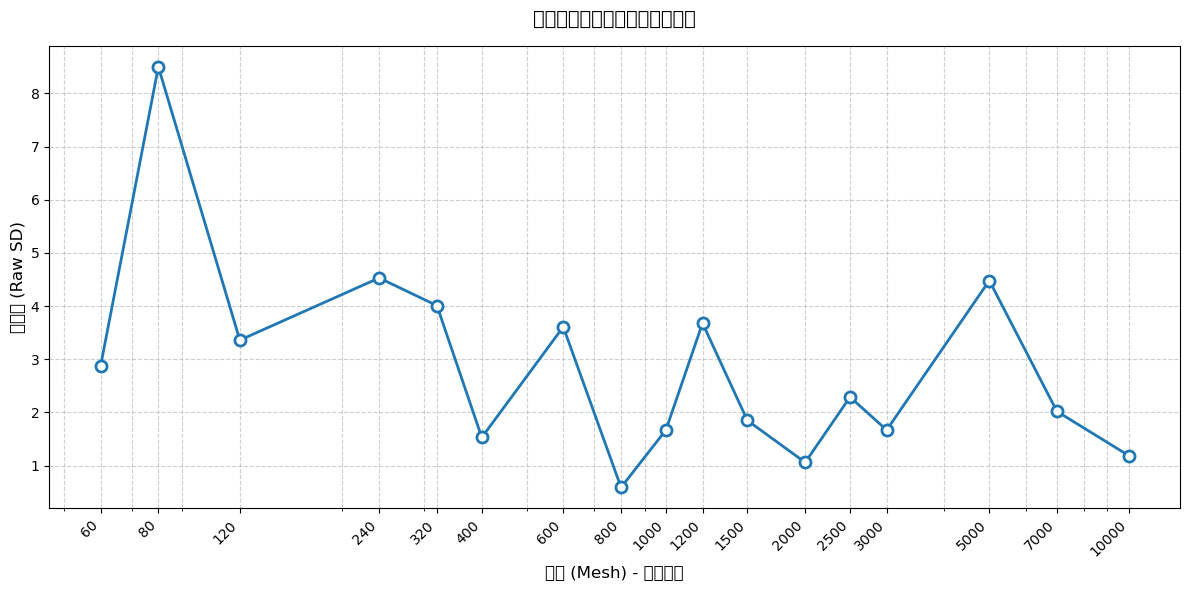

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
mesh_list = [60, 80, 120, 240, 320, 400, 600, 800, 1000, 1200, 1500, 2000, 2500, 3000, 5000, 7000, 10000]
raw_sds = [2.87, 8.50, 3.36, 4.53, 4.01, 1.53, 3.61, 0.59, 1.67, 3.68, 1.85, 1.06, 2.29, 1.67, 4.48, 2.02, 1.19]

# 创建图形
plt.figure(figsize=(12, 6), dpi=100)

# 使用对数刻度显示目数（更适合观察跨多个数量级的变化）
plt.xscale('log')

# 绘制折线 + 散点
plt.plot(mesh_list, raw_sds, 'o-', color='#1f77b4', linewidth=2, markersize=8, 
         markerfacecolor='white', markeredgewidth=2, label='标准差 (Raw SD)')

# 添加最高点标注（80目异常突出）
# max_sd_idx = np.argmax(raw_sds)
# plt.annotate(f'最大值: {raw_sds[max_sd_idx]:.2f}', 
#              xy=(mesh_list[max_sd_idx], raw_sds[max_sd_idx]),
#              xytext=(mesh_list[max_sd_idx]*1.8, raw_sds[max_sd_idx]+1.2),
#              arrowprops=dict(facecolor='red', shrink=0.05, width=1.5, headwidth=8),
#              fontsize=11, color='red')

# 美化
plt.title('不同目数下测量值的标准差分布', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('目数 (Mesh) - 对数刻度', fontsize=12)
plt.ylabel('标准差 (Raw SD)', fontsize=12)

# 网格
plt.grid(True, which="both", ls="--", alpha=0.6)

# x轴显示所有目数刻度
plt.xticks(mesh_list, mesh_list, rotation=45, ha='right', fontsize=10)

# 优化布局
plt.tight_layout()

# 可选：保存为高清图片
# plt.savefig('raw_sd_vs_mesh.png', dpi=300, bbox_inches='tight')

# 显示图形
plt.show()

In [ ]:
# Y-L拟合


In [ ]:
import cv2
import numpy as np
import os
from scipy.integrate import odeint
from scipy.optimize import minimize

# --- 全局变量 ---
points = []
current_img = None
img_display = None

# --- Young-Laplace 核心算法 ---

def yl_ode(vars, s, b, beta):
    """
    vars: [x, z, phi]
    b: 顶点曲率半径
    beta: 邦德数 (决定重力形变程度)
    """
    x, z, phi = vars
    if x < 1e-6:
        dphi_ds = 2.0 / b
    else:
        # 重力方向修正：在OpenCV中，液滴向下生长，z增加
        dphi_ds = (2.0 / b) + (beta * z) - (np.sin(phi) / x)
    
    dx_ds = np.cos(phi)
    dz_ds = np.sin(phi)
    return [dx_ds, dz_ds, dphi_ds]

def get_yl_curve(params):
    """根据参数生成理论曲线"""
    b, beta, x0, z0, s_max = params
    # 增加采样点确保交叉点精准
    s = np.linspace(0, abs(s_max), 500)
    try:
        sol = odeint(yl_ode, [1e-9, 0, 0], s, args=(b, beta), atol=1e-8, rtol=1e-8)
        # z0 是顶点y坐标，z增加意味着向图像下方生长
        fit_x = sol[:, 0] + x0
        fit_z = sol[:, 1] + z0
        phi_vals = sol[:, 2]
        return fit_x, fit_z, phi_vals
    except:
        return np.zeros(500), np.zeros(500), np.zeros(500)

def objective(params, target_pts):
    fx, fz, _ = get_yl_curve(params)
    # 计算5个手动点到理论曲线的距离平方和
    error = 0
    for px, pz in target_pts:
        dists = (fx - px)**2 + (fz - pz)**2
        # 同时考虑镜像部分（左侧）
        x_mirror = 2*params[2] - fx
        dists_mirror = (x_mirror - px)**2 + (fz - pz)**2
        error += min(np.min(dists), np.min(dists_mirror))
    return error

def solve_yl_params(manual_drop_pts):
    pts = np.array(manual_drop_pts)
    # 1. 自动寻找初始参数
    apex_idx = np.argmin(pts[:, 1])
    x_apex, y_apex = pts[apex_idx]
    
    # 粗略估算半径 b: 取最高点到两侧点水平距离的平均
    width_est = np.mean(np.abs(pts[:, 0] - x_apex))
    b_init = max(width_est, 10)
    
    # [b, beta, x0, z0, s_max]
    # beta 在像素坐标系下通常极小
    initial_guess = [b_init, 0.0001, x_apex, y_apex, b_init * 3.0]
    
    # 设定更合理的边界
    bounds = [
        (b_init*0.3, b_init*3.0),   # b: 顶点半径
        (-0.005, 0.005),             # beta: 允许微调形变
        (x_apex-30, x_apex+30),      # x0
        (y_apex-20, y_apex+20),      # z0
        (b_init, b_init*6.0)         # s_max: 确保够长能碰到基线
    ]
    
    res = minimize(objective, initial_guess, args=(pts,), 
                   bounds=bounds, method='SLSQP', options={'ftol': 1e-4})
    return res.x

# --- 交互界面 ---

def click_event(event, x, y, flags, param):
    global points, img_display
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((x, y))
        color = (0, 0, 255) if len(points) <= 5 else (0, 255, 255)
        cv2.circle(img_display, (x, y), 4, color, -1)
        cv2.putText(img_display, str(len(points)), (x+8, y-8), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
        cv2.imshow("Young-Laplace Fix", img_display)

def run_manual_marking(input_dir, output_dir):
    global points, current_img, img_display
    if not os.path.exists(output_dir): os.makedirs(output_dir)
    files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    for filename in files:
        points = []
        current_img = cv2.imread(os.path.join(input_dir, filename))
        if current_img is None: continue
        img_display = current_img.copy()
        cv2.imshow("Young-Laplace Fix", img_display)
        cv2.setMouseCallback("Young-Laplace Fix", click_event)
        
        while True:
            key = cv2.waitKey(1) & 0xFF
            if key == ord('r'):
                points = []; img_display = current_img.copy()
                cv2.imshow("Young-Laplace Fix", img_display)
            elif key == ord('q'): return
            elif key == ord('c') and len(points) == 7:
                # 处理逻辑
                drop_pts = points[:5]
                baseline_y = (points[5][1] + points[6][1]) / 2.0
                
                print(f"正在拟合 {filename}...")
                best_params = solve_yl_params(drop_pts)
                fx, fz, phi_vals = get_yl_curve(best_params)
                
                # 寻找与基准线交叉点
                # 由于z0在顶部，fz是增加的。我们要找 fz[i] >= baseline_y 的第一个点
                idx = np.where(fz >= baseline_y)[0]
                if len(idx) > 0:
                    intersect_idx = idx[0]
                    ca_deg = np.degrees(phi_vals[intersect_idx])
                else:
                    # 如果没够到，取最后一个点
                    ca_deg = np.degrees(phi_vals[-1])
                    print("警告：拟合曲线未触及基准线，请重新点选或检查基线位置")

                # 绘图
                res_plot = current_img.copy()
                # 画右侧
                pts_right = np.vstack((fx, fz)).T.astype(np.int32)
                cv2.polylines(res_plot, [pts_right], False, (0, 255, 0), 2)
                # 画左侧（镜像）
                pts_left = np.vstack((2*best_params[2] - fx, fz)).T.astype(np.int32)
                cv2.polylines(res_plot, [pts_left], False, (0, 255, 0), 2)
                # 画基线
                cv2.line(res_plot, (0, int(baseline_y)), (res_plot.shape[1], int(baseline_y)), (0, 255, 255), 1)
                
                cv2.putText(res_plot, f"CA: {ca_deg:.2f} deg", (50, 60), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)
                
                cv2.imshow("Young-Laplace Fix", res_plot)
                cv2.imwrite(os.path.join(output_dir, f"YL_{filename}"), res_plot)
                print(f"计算完成: {ca_deg:.2f}度")
                break

if __name__ == "__main__":
    input_folder = r"C:\Users\Admin\Desktop\CA\CA_photo"
    output_folder = r"C:\Users\Admin\Desktop\CA\CA_manual_yl_results"
    run_manual_marking(input_folder, output_folder)

--- Y-L 拟合 (5+2模式) 说明 ---
1. 在液滴弧线上【均匀】点击 5 个点 (红色)
2. 在水平基准线上点击 2 个点 (黄色)
3. 按 'c' 计算，'r' 重置，'q' 退出
正在处理: 1000-1.jpg...
成功！角度: 0.01°
正在处理: 1000-2.jpg...
成功！角度: -0.00°
正在处理: 1000-3.jpg...
成功！角度: -0.00°
正在处理: 10000-1.jpg...


: 